# Clustering

Vamos a implementar el modelo del paper [Multilingual E5 Text Embeddings: A Technical Report](https://arxiv.org/pdf/2402.05672) para construir embebimientos de cada tweet y luego visualizarlos.

In [1]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [2]:
# pip install transformers

In [ ]:
# pip install tidyX

In [62]:
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from tidyX import TextPreprocessor as tp

import os
import pickle
import pandas as pd
import numpy as np

In [4]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [5]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

In [67]:
# We load the tweets
archivos = os.listdir('/mnt/disk2/Data/Tweets_DataFrames/Tweets_Paro_Total')
# Do a test with one file
df = pd.read_pickle(r'/mnt/disk2/Data/Tweets_DataFrames/Tweets_Paro_Total/tweets_paro_1.gzip', compression = 'gzip')
df = df.reset_index(drop = True)

In [68]:
# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.

input_texts = df.loc[0:100, "Text"]
input_texts = input_texts.apply(lambda x: tp.preprocess(str(x)))
input_texts = "passage: " + input_texts
input_texts = input_texts.values
input_texts = input_texts.tolist()

In [69]:
input_texts

['passage: un adulto mayor resulto afectado tras intervencion del esmad en suba',
 'passage: otra persona sufriendo convulsiones en fontanar producto de la represion usted dio la orden',
 'passage: aqui les informamos en este preciso momento en inmediaciones del parque fontanar en la localidad de suba en bogota se vive una violenta represion policial ya se reportan varios heridos y desaparecidos fuente tropa digital pablo ubedani',
 'passage: andres cardona reportero grafico de y de varios medios internacionales acaba de ser atacado por el esmad en suba via',
 'passage: maria jovita osorio de anos murio en cali luego de que un proyectil de gas lacrimogeno se dispersara por su casa y le provocara fallos seguidos en el corazon',
 'passage: no se les olvide prendan notificaciones del que va a estar tremendo descuentos beneficios y cosas hermosas apoyen con un rt que todos conozcan los emprendimientos participantes',
 'passage: en acaba de fallecer nuestro hermano zacarias llego de ayacuch

In [70]:
# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length = 512, padding = True, truncation = True, return_tensors = 'pt')

In [71]:
outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [72]:
# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)

In [73]:
embeddings

tensor([[ 0.0291, -0.0045, -0.0194,  ..., -0.0051, -0.0309,  0.0212],
        [ 0.0299, -0.0047, -0.0373,  ...,  0.0130, -0.0307,  0.0116],
        [ 0.0257, -0.0121, -0.0490,  ...,  0.0210, -0.0167, -0.0036],
        ...,
        [ 0.0382, -0.0116, -0.0179,  ..., -0.0045, -0.0129,  0.0294],
        [ 0.0272,  0.0148, -0.0414,  ...,  0.0112, -0.0329, -0.0058],
        [ 0.0101,  0.0010, -0.0071,  ..., -0.0100, -0.0152,  0.0033]],
       grad_fn=<DivBackward0>)

In [79]:
from sklearn.cluster import KMeans
n_clusters = 4  

kmeans = KMeans(n_clusters = n_clusters, random_state = 666)
kmeans.fit(embeddings.detach().numpy())

cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [80]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [82]:
tsne = TSNE(n_components = 2, random_state = 666)
embeddings_2d = tsne.fit_transform(embeddings.detach().numpy())

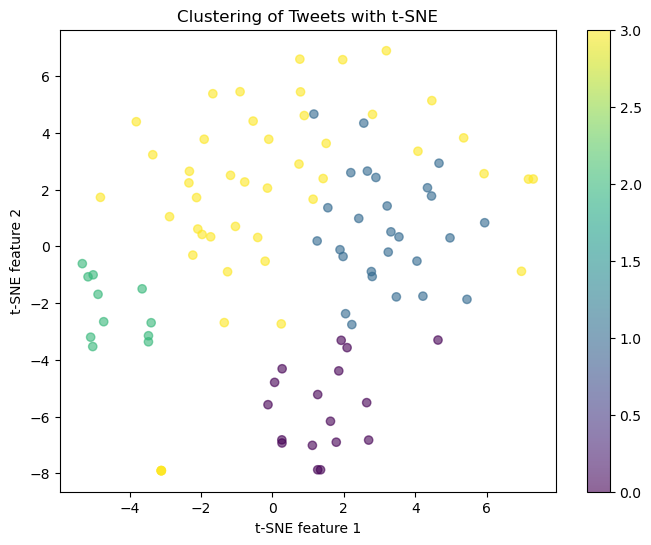

In [85]:
plt.figure(figsize = (8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c = cluster_labels, cmap = 'viridis', alpha = 0.6)
plt.colorbar(scatter)
plt.title('Clustering of Tweets with t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [93]:
np.array(input_texts)[cluster_labels == 0]

array(['passage: un adulto mayor resulto afectado tras intervencion del esmad en suba',
       'passage: que tal funciona la justicia colombiana ya le muestro',
       'passage: persiste la represion del esmad contra manifestantes en fontanar suba',
       'passage: construyendo el por todo el caribe',
       'passage: que tal dificil es',
       'passage: atencion el alcalde de jamundi acaba de declarar alerta roja hospitalaria',
       'passage: jim mcgovern que nada de nuestro dinero vaya a la policia de colombia',
       'passage: no se necesitan palabras',
       'passage: este esquema lo convirtieron en politica estatal',
       'passage: pero sobre todo es hijueputa',
       'passage: esto es de no creer esto es absurdo e irrespetuoso',
       'passage: no quedaran en el olvido',
       'passage: lo logramos ayer llegamos a la jep donde termina la cifra de',
       'passage: esto de esos miembros del esmad es de salvajes',
       'passage: esto es simplemente distopico',
       

In [94]:
np.array(input_texts)[cluster_labels == 1]

array(['passage: otra persona sufriendo convulsiones en fontanar producto de la represion usted dio la orden',
       'passage: aqui les informamos en este preciso momento en inmediaciones del parque fontanar en la localidad de suba en bogota se vive una violenta represion policial ya se reportan varios heridos y desaparecidos fuente tropa digital pablo ubedani',
       'passage: andres cardona reportero grafico de y de varios medios internacionales acaba de ser atacado por el esmad en suba via',
       'passage: maria jovita osorio de anos murio en cali luego de que un proyectil de gas lacrimogeno se dispersara por su casa y le provocara fallos seguidos en el corazon',
       'passage: es lamentable lo que esta sucediendo en suba en bogota la fuerza publica sin contemplacion agrede a manifestantes que incluso estan heridos y convulsionando la historia de colombia hoy es sin duda un escenario de barbarie similar al de pinochet videla y demas dictadores',
       'passage: agredir a peri

In [95]:
np.array(input_texts)[cluster_labels == 2]

array(['passage: increible la ordena ampliar denuncia contra por dar proteccion a jovenes indefensos contra la brutalidad del esmad y se abstiene de llamar a juicio a marta lucia ramirez por vinculos comerciales con el memo fantasma y con el sr salvatore mancuso',
       'passage: cosas que quieren minimizar captura del narco memo fantasma y sus vinculos con politicos activos las graves declaraciones de salvatore mancuso uso de recursos publicos para negocios privados por parte de sarmiento angulo cierto',
       'passage: fiscalia dice que memo fantasma habria lavado mil millones de paramilitares noticentro cm amp',
       'passage: mancuso declaro que el asesinato de jaime garzon se ejecuto porque se recibieron ordenes de bien arriba del estado alvaro uribe era el jefe del estado el hombre que estaba bien arriba',
       'passage: mancuso afirmo que jaime garzon fue estigmatizado ante la opinion publica para legitimar su asesinato asesinato que cometieron las auc por pedido de podero